## Topic classification using BoW Embeddings

In [2]:
import pandas as pd
df_cleaned = pd.read_csv("../../data/cleaned_merged_all_articles.csv", index_col=0).drop(columns=['title', 'representative_name', 'representative_state', 'representative_party', 'representative_committee', 'date'])
df_single_issue = df_cleaned[~df_cleaned['issue'].str.contains(';')]
selected_issues = [
    "Energy and Environment", "Education", "Health Care and Social Security", "Jobs and the Economy",
				"National Security, Defence, Foreign Affairs", "Veterans and Military"
  ]
df = df_single_issue[df_single_issue['issue'].isin(selected_issues)]
df.groupby("issue")["text"].count()

issue
Education                                      1411
Energy and Environment                         2380
Health Care and Social Security                2930
Jobs and the Economy                           2333
National Security, Defence, Foreign Affairs    3673
Veterans and Military                          1376
Name: text, dtype: int64

In [3]:
import re
import nltk
from nltk.stem import WordNetLemmatizer

stop_words_path = "../SmartStoplist.txt"
lemmatizer = WordNetLemmatizer()

def load_stop_words():
    stop_words = []
    with open(stop_words_path, "r") as f:
        stop_words = f.read().split("\n")
    return set(stop_words)

def preprocess_text(text: str, stopwords) -> str:
    text = re.sub(r"http\S+", "", text) # remove links
    text = re.sub("[^A-Za-z]+", " ", text) # remove special characters and numbers
    tokens = nltk.word_tokenize(text.lower()) # tokenization
    tokens = [w for w in tokens if not w in stopwords] # remove stop words
    tokens = [lemmatizer.lemmatize(w) for w in tokens] # remove stop words + lemmatization
    text = " ".join(tokens)
    text = text.lower().strip()
    return text


stopwords = load_stop_words()
df.loc[:, "text"] = df["text"].apply(lambda text: preprocess_text(text, stopwords))
df = df[df["text"] != ""]

In [4]:
most_common_words=[
    'state', 'act', 'community', 'federal', 'year', 'american', 'rep', 'house', 'congressman', 'program', 'today', 'service', 'support', 'member', 'committee'
]

CountVectorizer creates a Bag of Words representation of the text data.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch import nn
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['issue'])

# Split the dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# Initialize CountVectorizer for BoW
vectorizer = CountVectorizer(ngram_range=(1,4), stop_words=most_common_words, min_df=100)
train_embeddings = vectorizer.fit_transform(train_texts.tolist()).toarray()
val_embeddings = vectorizer.transform(val_texts.tolist()).toarray()

# Convert to tensors
train_embeddings_tensor = torch.tensor(train_embeddings, dtype=torch.float32)
val_embeddings_tensor = torch.tensor(val_embeddings, dtype=torch.float32)

train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

# Create datasets
train_dataset = TensorDataset(train_embeddings_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_embeddings_tensor, val_labels_tensor)

# Data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

Troubles with Count vectorizer:
```
Unable to allocate 404. GiB for an array with shape (11282, 4805714) and data type int64
```

In [6]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, model, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            torch.save(model.state_dict(), 'checkpoint.pt')
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


class SimpleNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleNN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.fc(x)


def train(classifier, criterion, optimizer, train_loader, val_loader, epochs=30, patience=3, min_delta=10):
	if patience is None or min_delta is None:
		early_stopper = lambda x: False
	else:
		early_stopper = EarlyStopper(patience=patience, min_delta=min_delta)

	losses = []
	val_losses = []
	for epoch in range(epochs):  # Train for 10 epochs
					classifier.train()
					for batch in train_loader:
									optimizer.zero_grad()

									embeddings, labels = batch
									embeddings = embeddings.to(device)
									labels = labels.to(device).long()

									outputs = classifier(embeddings)
									loss = criterion(outputs, labels)
									loss.backward()
									optimizer.step()
									

					final_loss = loss.item()
					classifier.eval()
					with torch.no_grad():
						for batch in val_loader:
							embeddings, labels = batch
							embeddings = embeddings.to(device)
							labels = labels.to(device).long()

							outputs = classifier(embeddings)
							val_loss = criterion(outputs, labels).item()
					print(f"Epoch {epoch + 1}, Loss: {final_loss}, Val loss: {val_loss}")
					losses.append(final_loss)
					val_losses.append(val_loss)
					if early_stopper.early_stop(classifier, val_loss):
						break
  
	if patience is not None and min_delta is not None:
		classifier.load_state_dict(torch.load('checkpoint.pt', weights_only=True))

	return losses, val_losses

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [8]:
def evaluate(classifier, val_loader):
	classifier.eval()
	all_predictions = []
	all_labels = []
	with torch.no_grad():
					for batch in val_loader:
									embeddings, labels = batch
									embeddings = embeddings.to(device)
									labels = labels.to(device).long()

									outputs = classifier(embeddings)
									predictions = torch.argmax(outputs, dim=-1)

									all_predictions.extend(predictions.cpu().numpy())
									all_labels.extend(labels.cpu().numpy())

	# Generate classification report
	print(classification_report(all_labels, all_predictions, target_names=label_encoder.classes_))

	# Generate confusion matrix
	cm = confusion_matrix(all_labels, all_predictions)
	cm_display_labels = label_encoder.classes_

	# Plot confusion matrix
	plt.figure(figsize=(10, 8))
	sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cm_display_labels, yticklabels=cm_display_labels)
	plt.xlabel('Predicted Label')
	plt.ylabel('True Label')
	plt.title('Confusion Matrix')
	plt.show()

In [9]:
model_simple = SimpleNN(input_dim=train_embeddings_tensor.size(1), num_classes=len(df['issue'].unique()))
model_simple.to(device)

criterion_cros_entr_loss = nn.CrossEntropyLoss()
optimizer_adam = torch.optim.Adam(model_simple.parameters(), lr=5e-5, weight_decay=1e-6)
losses, val_losses = train(model_simple, criterion_cros_entr_loss, optimizer_adam, train_loader, val_loader, 500, patience=3, min_delta=2)

Epoch 1, Loss: 0.9714833498001099, Val loss: 0.5981310606002808
Epoch 2, Loss: 0.5819183588027954, Val loss: 0.29698580503463745
Epoch 3, Loss: 0.5802609324455261, Val loss: 0.20731088519096375
Epoch 4, Loss: 0.27134525775909424, Val loss: 0.16404613852500916
Epoch 5, Loss: 0.43883979320526123, Val loss: 0.14946439862251282
Epoch 6, Loss: 0.3101712167263031, Val loss: 0.1289902925491333
Epoch 7, Loss: 0.16140897572040558, Val loss: 0.13438428938388824
Epoch 8, Loss: 0.07177339494228363, Val loss: 0.12228177487850189
Epoch 9, Loss: 0.29771602153778076, Val loss: 0.11484559625387192
Epoch 10, Loss: 0.40414929389953613, Val loss: 0.11029776185750961
Epoch 11, Loss: 0.43695661425590515, Val loss: 0.11722324043512344
Epoch 12, Loss: 0.1121353730559349, Val loss: 0.10023325681686401
Epoch 13, Loss: 0.0968669205904007, Val loss: 0.0977129340171814
Epoch 14, Loss: 0.08409886062145233, Val loss: 0.10285484790802002
Epoch 15, Loss: 0.06923729926347733, Val loss: 0.08487759530544281
Epoch 16, Los

                                             precision    recall  f1-score   support

                                  Education       0.88      0.86      0.87       282
                     Energy and Environment       0.91      0.93      0.92       476
            Health Care and Social Security       0.90      0.91      0.90       586
                       Jobs and the Economy       0.87      0.82      0.84       467
National Security, Defence, Foreign Affairs       0.91      0.93      0.92       735
                      Veterans and Military       0.86      0.86      0.86       275

                                   accuracy                           0.89      2821
                                  macro avg       0.89      0.88      0.89      2821
                               weighted avg       0.89      0.89      0.89      2821



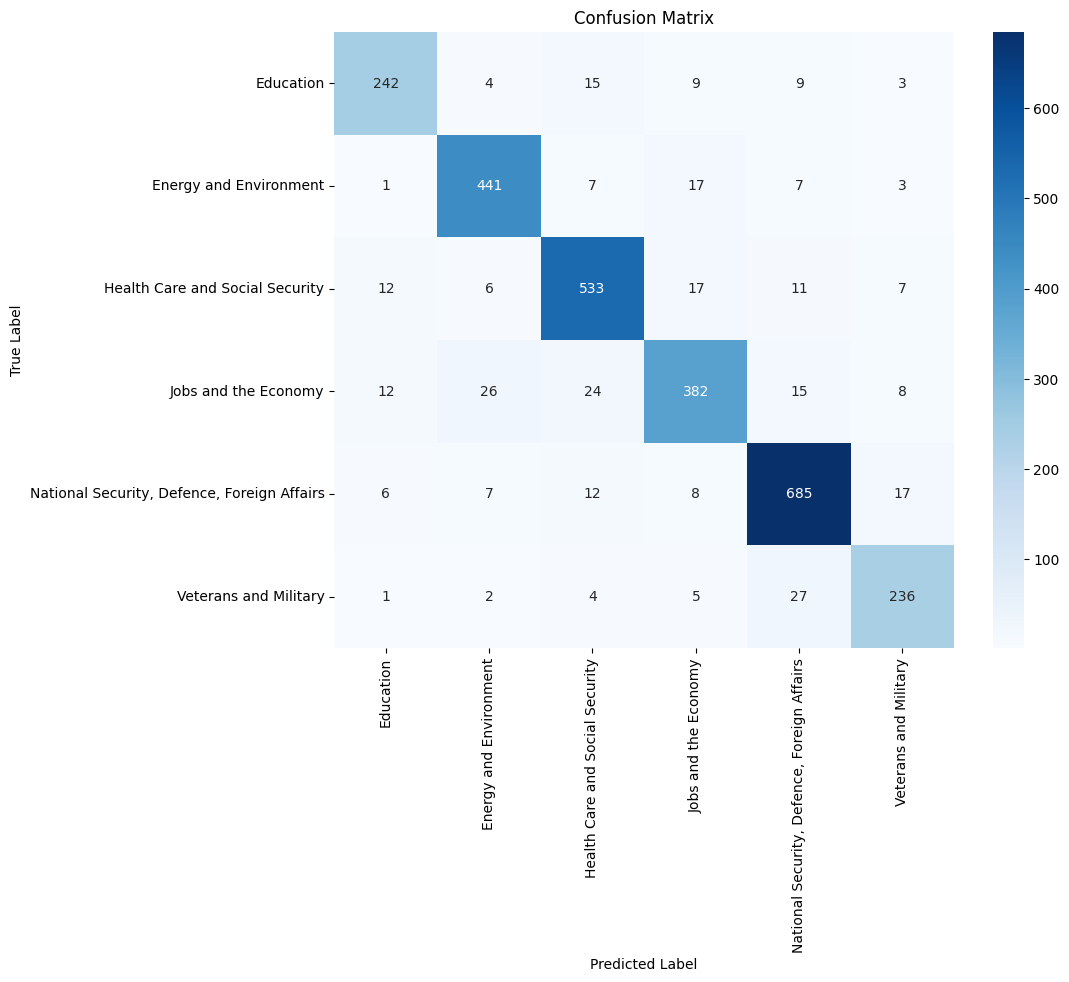

In [10]:
evaluate(model_simple, val_loader)

In [11]:
import matplotlib.pyplot as plt

def plot_training(losses, val_losses, start_epoch = 0, end_epoch=-1):
	plt.figure(figsize=(8, 6))
	plt.plot(list(range(1, len(losses[start_epoch:end_epoch])+1)), losses[start_epoch:end_epoch], marker='o', linestyle='-', color='r', label='Train Loss')
	plt.plot(list(range(1, len(val_losses[start_epoch:end_epoch])+1)), val_losses[start_epoch:end_epoch], marker='o', linestyle='-', color='b', label='Validation Loss')

	# Add labels and title
	plt.xlabel('Epoch')
	plt.ylabel('Training loss')
	plt.title('Training and validation loss (1st model)')
	plt.legend()

	# Show the plot
	plt.grid()
	plt.show()

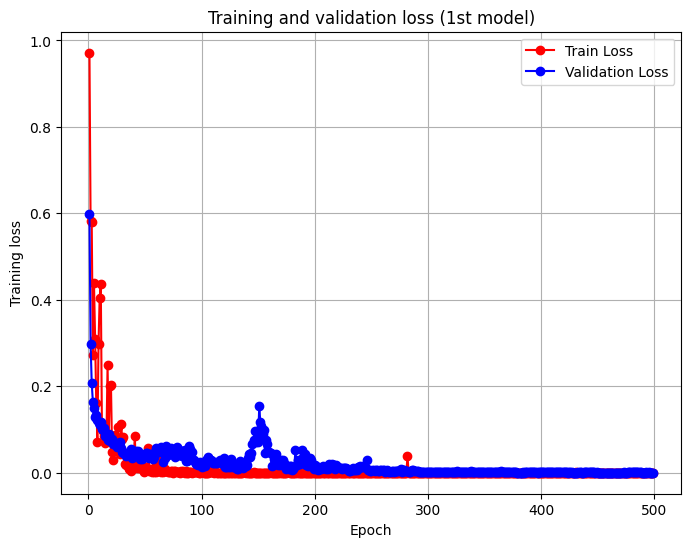

In [12]:
plot_training(losses, val_losses)

---

## Slightly more difficult model

In [13]:
class SlightlyMoreDifficultNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SlightlyMoreDifficultNN, self).__init__()
        self.fc = nn.Sequential(
								nn.Linear(input_dim, 256),
								nn.ReLU(),
								nn.Dropout(0.4),
								nn.Linear(256, 128),
								nn.ReLU(),
								nn.Dropout(0.3),
								nn.Linear(128, num_classes)
							)

    def forward(self, x):
        return self.fc(x)

In [14]:
model_more_diff = SlightlyMoreDifficultNN(input_dim=train_embeddings_tensor.size(1), num_classes=len(df['issue'].unique()))
model_more_diff.to(device)

optimizer_adam_diff = torch.optim.Adam(model_more_diff.parameters(), lr=5e-5, weight_decay=1e-6)
losses, val_losses = train(model_more_diff, criterion_cros_entr_loss, optimizer_adam_diff, train_loader, val_loader, 300, patience=3, min_delta=2)

Epoch 1, Loss: 0.9038002490997314, Val loss: 0.545976996421814
Epoch 2, Loss: 0.4906783103942871, Val loss: 0.1783275306224823
Epoch 3, Loss: 0.3094697892665863, Val loss: 0.11405178159475327
Epoch 4, Loss: 0.10060684382915497, Val loss: 0.09566760063171387
Epoch 5, Loss: 0.35567706823349, Val loss: 0.08950722217559814
Epoch 6, Loss: 0.23239275813102722, Val loss: 0.08880974352359772
Epoch 7, Loss: 0.1578444540500641, Val loss: 0.09433817863464355
Epoch 8, Loss: 0.15985457599163055, Val loss: 0.09965205192565918
Epoch 9, Loss: 0.45645666122436523, Val loss: 0.0689120665192604
Epoch 10, Loss: 0.14245672523975372, Val loss: 0.08962737023830414
Epoch 11, Loss: 0.4867096543312073, Val loss: 0.06152849271893501
Epoch 12, Loss: 0.23631031811237335, Val loss: 0.0663352981209755
Epoch 13, Loss: 0.09713073074817657, Val loss: 0.06338061392307281
Epoch 14, Loss: 0.1433689296245575, Val loss: 0.07862873375415802
Epoch 15, Loss: 0.04991815611720085, Val loss: 0.06143372505903244
Epoch 16, Loss: 0.

                                             precision    recall  f1-score   support

                                  Education       0.89      0.88      0.88       282
                     Energy and Environment       0.89      0.93      0.91       476
            Health Care and Social Security       0.89      0.91      0.90       586
                       Jobs and the Economy       0.87      0.80      0.84       467
National Security, Defence, Foreign Affairs       0.91      0.94      0.92       735
                      Veterans and Military       0.88      0.85      0.87       275

                                   accuracy                           0.89      2821
                                  macro avg       0.89      0.88      0.89      2821
                               weighted avg       0.89      0.89      0.89      2821



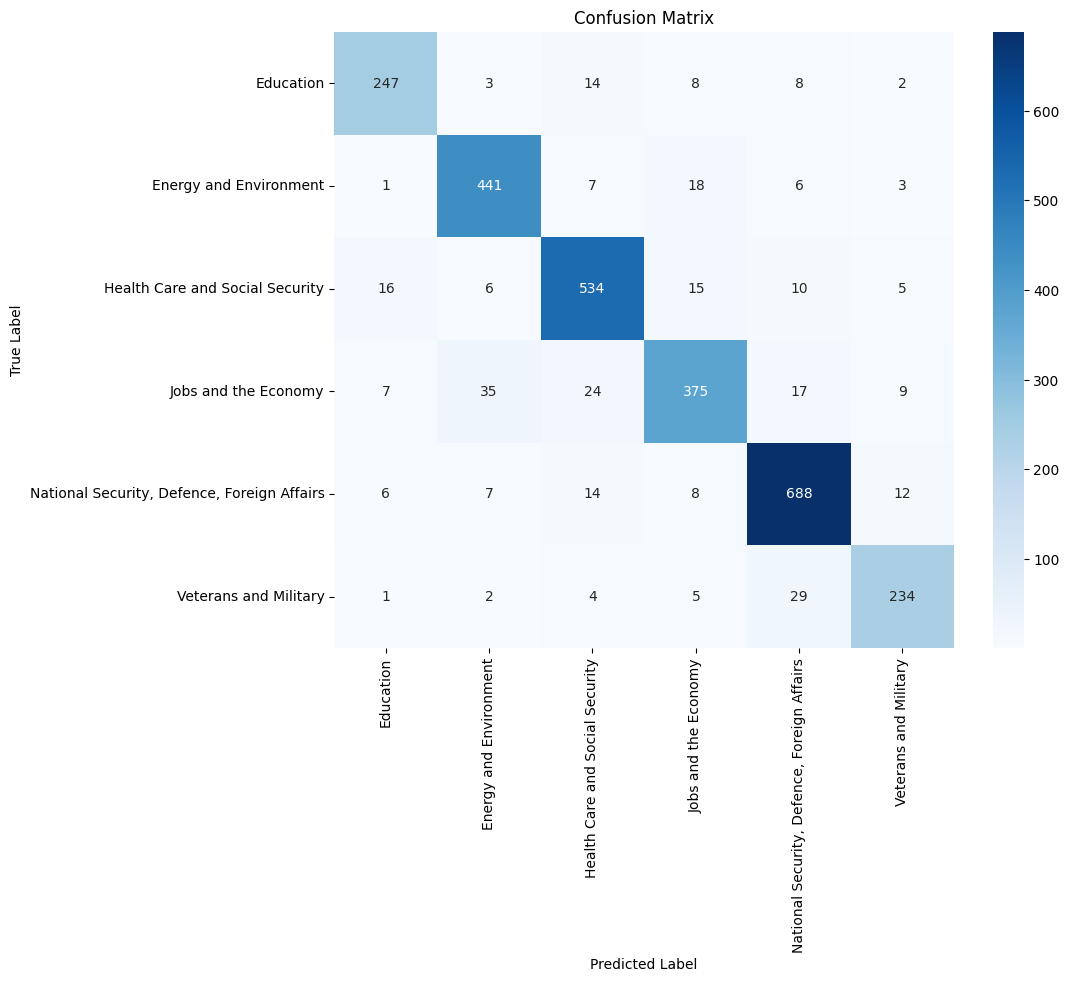

In [15]:
evaluate(model_more_diff, val_loader)

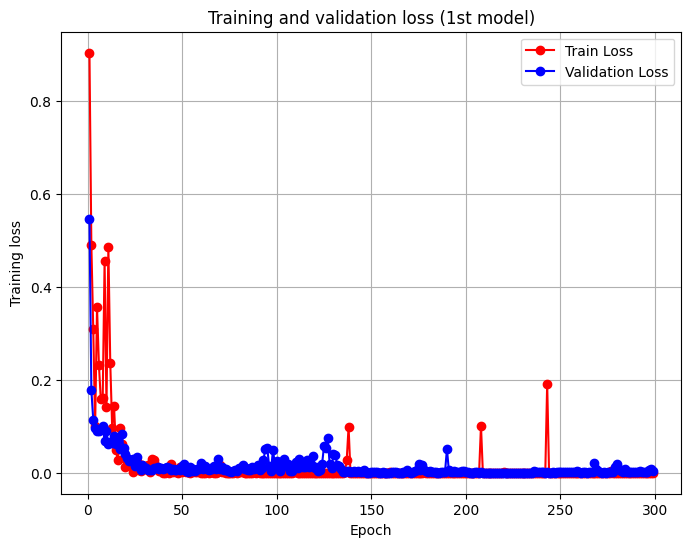

In [16]:
plot_training(losses, val_losses)

----

In [17]:
class SimpleNN2(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleNN2, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

In [18]:
model = SimpleNN2(input_dim=train_embeddings_tensor.size(1), num_classes=len(df['issue'].unique()))
model.to(device)

optimizer_adam = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-6)
losses, val_losses = train(model, criterion_cros_entr_loss, optimizer_adam, train_loader, val_loader, 500, patience=3, min_delta=2)

Epoch 1, Loss: 1.5189467668533325, Val loss: 1.2572920322418213
Epoch 2, Loss: 0.9547970294952393, Val loss: 0.540849506855011
Epoch 3, Loss: 0.44411590695381165, Val loss: 0.27809393405914307
Epoch 4, Loss: 0.9264432191848755, Val loss: 0.17192193865776062
Epoch 5, Loss: 0.3736676871776581, Val loss: 0.12764127552509308
Epoch 6, Loss: 0.49080145359039307, Val loss: 0.09333975613117218
Epoch 7, Loss: 0.7839077115058899, Val loss: 0.08723493665456772
Epoch 8, Loss: 0.33780980110168457, Val loss: 0.07677064836025238
Epoch 9, Loss: 0.37861427664756775, Val loss: 0.07604556530714035
Epoch 10, Loss: 0.3864438831806183, Val loss: 0.07278971374034882
Epoch 11, Loss: 0.6367123126983643, Val loss: 0.06673411279916763
Epoch 12, Loss: 0.27440837025642395, Val loss: 0.0692363977432251
Epoch 13, Loss: 0.09275774657726288, Val loss: 0.04833536595106125
Epoch 14, Loss: 0.12270358204841614, Val loss: 0.05375519394874573
Epoch 15, Loss: 0.18243657052516937, Val loss: 0.05840126425027847
Epoch 16, Loss:

                                             precision    recall  f1-score   support

                                  Education       0.88      0.88      0.88       282
                     Energy and Environment       0.92      0.92      0.92       476
            Health Care and Social Security       0.89      0.91      0.90       586
                       Jobs and the Economy       0.85      0.82      0.83       467
National Security, Defence, Foreign Affairs       0.90      0.93      0.92       735
                      Veterans and Military       0.89      0.84      0.86       275

                                   accuracy                           0.89      2821
                                  macro avg       0.89      0.88      0.89      2821
                               weighted avg       0.89      0.89      0.89      2821



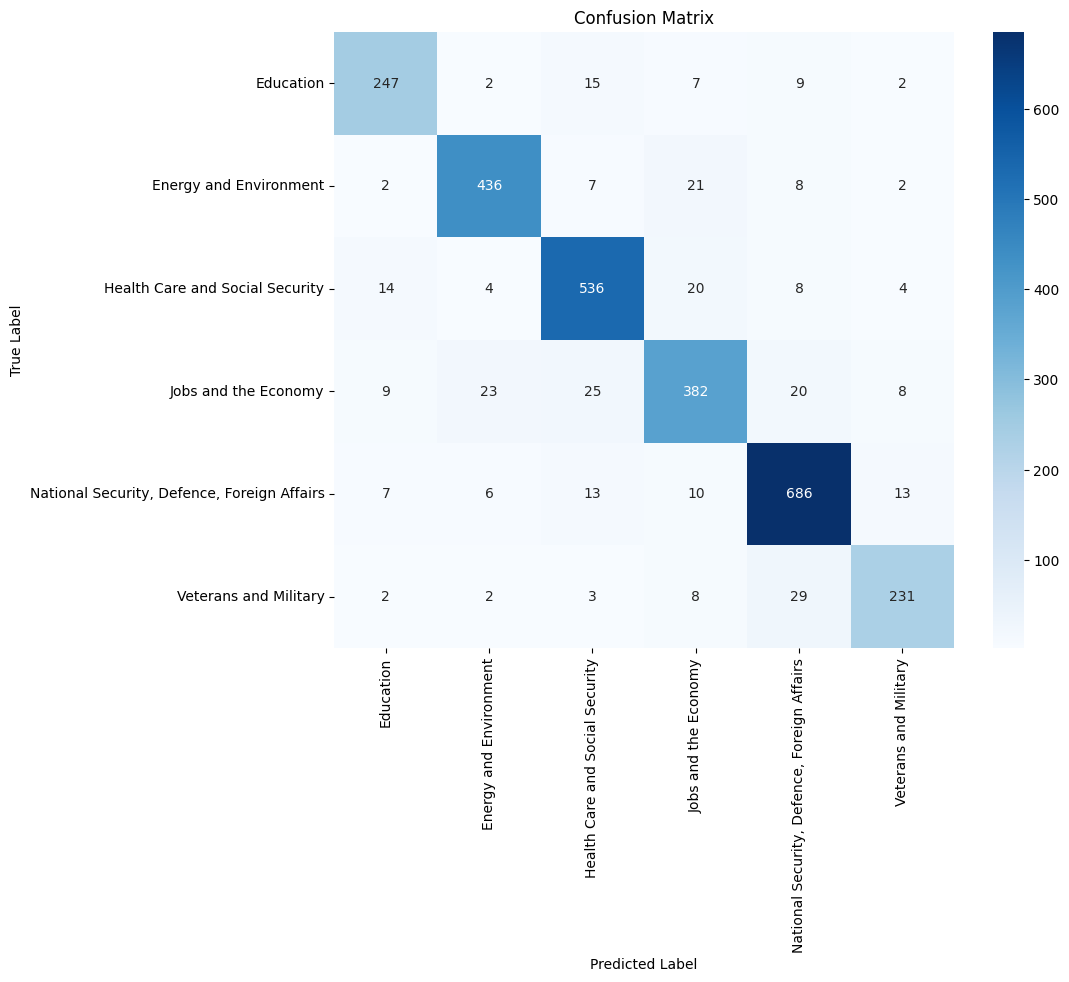

In [19]:
evaluate(model, val_loader)

---

In [20]:
class SimpleNN3(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleNN3, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

In [21]:
model = SimpleNN3(input_dim=train_embeddings_tensor.size(1), num_classes=len(df['issue'].unique()))
model.to(device)

optimizer_adam = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-6)
losses, val_losses = train(model, criterion_cros_entr_loss, optimizer_adam, train_loader, val_loader, 500, patience=3, min_delta=2)

Epoch 1, Loss: 1.4070945978164673, Val loss: 1.2952731847763062
Epoch 2, Loss: 1.098154902458191, Val loss: 0.40913352370262146
Epoch 3, Loss: 0.6965097784996033, Val loss: 0.16649436950683594
Epoch 4, Loss: 0.5514711737632751, Val loss: 0.10687990486621857
Epoch 5, Loss: 0.2992018163204193, Val loss: 0.08502279222011566
Epoch 6, Loss: 0.3639615476131439, Val loss: 0.07867614924907684
Epoch 7, Loss: 0.6491162180900574, Val loss: 0.07337441295385361
Epoch 8, Loss: 0.42249399423599243, Val loss: 0.08008648455142975
Epoch 9, Loss: 0.2974325120449066, Val loss: 0.05575869604945183
Epoch 10, Loss: 0.06466438621282578, Val loss: 0.11059725284576416
Epoch 11, Loss: 0.2558947801589966, Val loss: 0.07113975286483765
Epoch 12, Loss: 0.19385576248168945, Val loss: 0.07386408001184464
Epoch 13, Loss: 0.06683279573917389, Val loss: 0.05786828324198723
Epoch 14, Loss: 0.07705247402191162, Val loss: 0.08594183623790741
Epoch 15, Loss: 0.7770712375640869, Val loss: 0.08307784795761108
Epoch 16, Loss: 

                                             precision    recall  f1-score   support

                                  Education       0.88      0.86      0.87       282
                     Energy and Environment       0.90      0.93      0.91       476
            Health Care and Social Security       0.89      0.92      0.91       586
                       Jobs and the Economy       0.88      0.81      0.84       467
National Security, Defence, Foreign Affairs       0.91      0.93      0.92       735
                      Veterans and Military       0.88      0.84      0.86       275

                                   accuracy                           0.89      2821
                                  macro avg       0.89      0.88      0.89      2821
                               weighted avg       0.89      0.89      0.89      2821



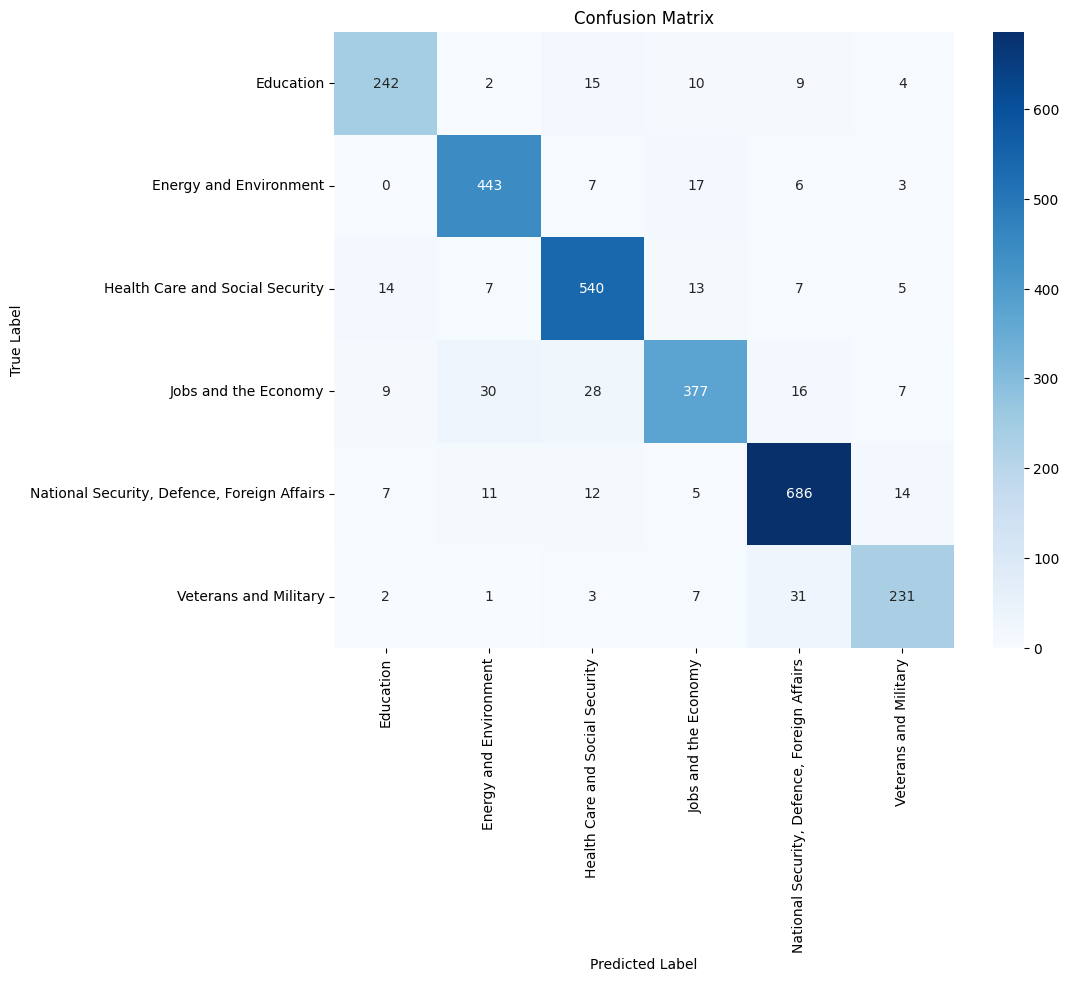

In [22]:
evaluate(model, val_loader)

In [23]:
class SimpleNN4(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleNN4, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.fc(x)

In [24]:
model = SimpleNN4(input_dim=train_embeddings_tensor.size(1), num_classes=len(df['issue'].unique()))
model.to(device)

optimizer_adam = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-6)
losses, val_losses = train(model, criterion_cros_entr_loss, optimizer_adam, train_loader, val_loader, 500, patience=3, min_delta=2)

Epoch 1, Loss: 1.4832844734191895, Val loss: 1.0337707996368408
Epoch 2, Loss: 0.729291558265686, Val loss: 0.3401048481464386
Epoch 3, Loss: 0.9672403335571289, Val loss: 0.2127912938594818
Epoch 4, Loss: 1.1052964925765991, Val loss: 0.13062122464179993
Epoch 5, Loss: 0.39254796504974365, Val loss: 0.08955935388803482
Epoch 6, Loss: 0.14664237201213837, Val loss: 0.0587630569934845
Epoch 7, Loss: 0.3782511055469513, Val loss: 0.05175991728901863
Epoch 8, Loss: 0.19625864923000336, Val loss: 0.03597329556941986
Epoch 9, Loss: 0.2996827960014343, Val loss: 0.03445405140519142
Epoch 10, Loss: 0.2658180594444275, Val loss: 0.028246304020285606
Epoch 11, Loss: 0.1322803646326065, Val loss: 0.030724216252565384
Epoch 12, Loss: 0.1503596007823944, Val loss: 0.02647542580962181
Epoch 13, Loss: 0.23893684148788452, Val loss: 0.020630788058042526
Epoch 14, Loss: 0.3013409674167633, Val loss: 0.011921023018658161
Epoch 15, Loss: 0.0666758194565773, Val loss: 0.011803196743130684
Epoch 16, Loss:

                                             precision    recall  f1-score   support

                                  Education       0.89      0.87      0.88       282
                     Energy and Environment       0.92      0.92      0.92       476
            Health Care and Social Security       0.91      0.90      0.90       586
                       Jobs and the Economy       0.84      0.84      0.84       467
National Security, Defence, Foreign Affairs       0.92      0.94      0.93       735
                      Veterans and Military       0.86      0.85      0.85       275

                                   accuracy                           0.89      2821
                                  macro avg       0.89      0.88      0.89      2821
                               weighted avg       0.89      0.89      0.89      2821



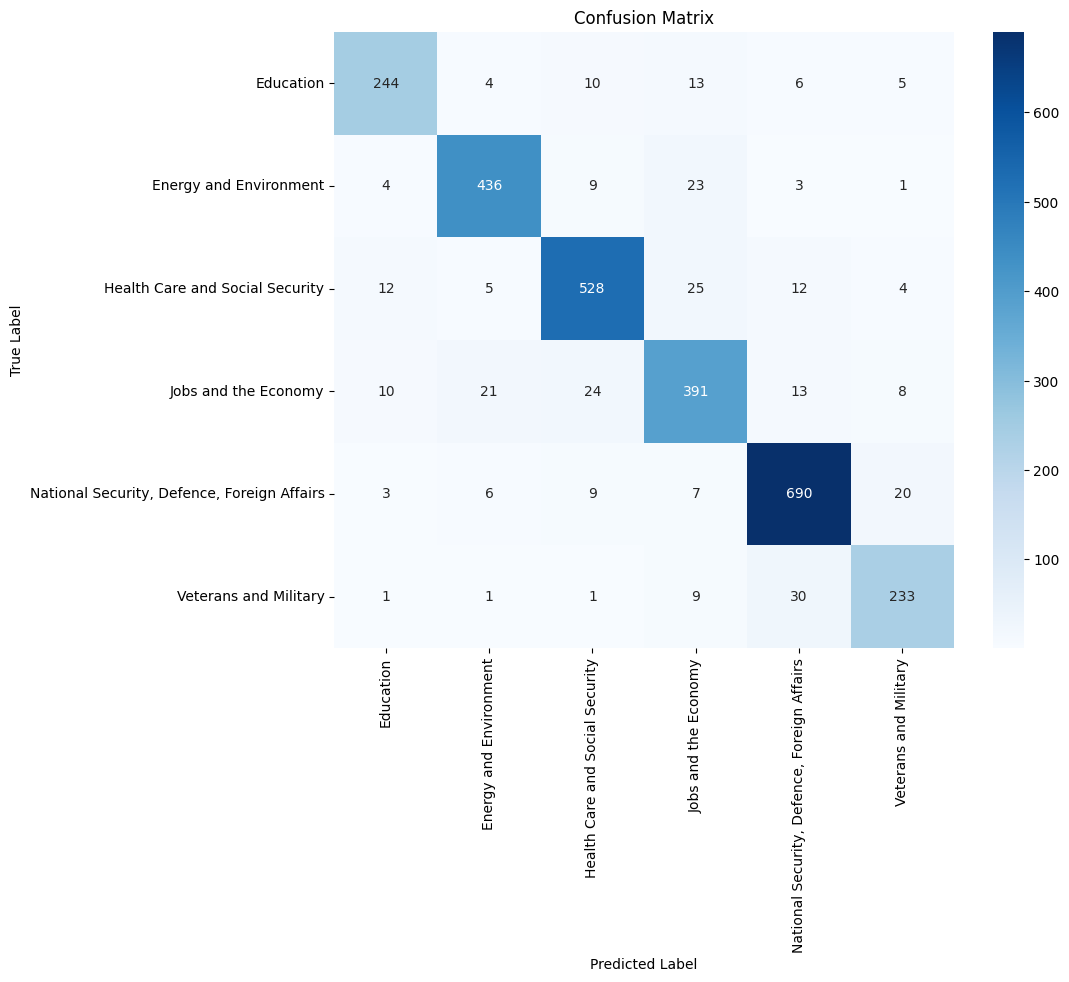

In [25]:
evaluate(model, val_loader)